# Lab Two: Exploring Image Data

#### *Harrison Noble, Henry Lambson*


## 1. Business Understanding

### 1.1 Overview of the Dataset

The dataset we selected contains pictures of faces that are either real, or have been edited. The edited photos have been categorized into easy, mid, and hard in terms of the difficulty to determine that they are fake. The dataset made it clear that these groupings are subjective and as such will not be used as explicit categories. Instead we will just be focusing on whether the image is real or fake. Additionally, each fake image contains encoded data in the filename. The image below explains the encoding.

![Image from dataset](https://raw.githubusercontent.com/minostauros/Real-and-Fake-Face-Detection/master/filename_description.jpg)
__Note:__ This image was taken directly from resource 1, we found it much easier to include the picture rather than try to explain the encoding in words.

There are 960 fake images and 1081 real images in the dataset. 

### 1.2 Purpose of the Data

This data was gathered in 2019 and according to reference 1, it was gathered for the purpose of training an algorithm to distinguish fake or edited images of faces from real, unedited ones. 

### 1.3 Prediction Task for Dataset

To determine whether a photo on social media has been edited or doctored in some way. This could be useful to find and dispose of bot or fake accounts.  

### 1.4 Data Importance

This data is important because it can help stop the spread of misleading images such as scammers using fake images for their accounts, or a deep-fake generated incriminating or slandering image of someone. Social media has become such a large part of society so an algorithm that helps detect doctored photos could be useful in a moderating capacity, whether that be flagging images that are detected to be fake, or banning the accounts that use the photos. Since the dataset is only made up of faces, these would be the only kinds of images that could be detected by the algorithm.       

### 1.5 Prediction Algorithm Performace to be Considered Useful

We believe that for this algorithm to be useful, it would need to be quite accurate in order to prevent unjust bans or flags on social media images. To that end, we would want to reduce the amount of false-positives so that regular users are not affected. Given the number of images posted to social media in a day, we would want our algorithm to have a success rate somewhere in the range of 95-98%. Instead of outright banning users, the algorithm would flag an account to be reviewed manually if multiple infractions are detected.   

## 2. Data Preparation

### 2.1 Read in, Preprocess, and Linearize Data


In [21]:
import os
import zipfile
import glob
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

#unzip data (only do once, uncomment to unzip data)
# with zipfile.ZipFile('dataset.zip', 'r') as zipf:
#     zipf.extractall('./data')

fake_face_path = 'data/real_and_fake_face/training_fake/*'
real_face_path = 'data/real_and_fake_face/training_real/*'

#desired height and width of images
h = 200
w = 200

def load_data(path):
    files = glob.glob(path)
    
    img_list = []
    f_name = []
    for file in files:
        #create image, resize to 200x200, convert to grayscale
        img = Image.open(file)
        img = img.resize((h, w))
        img = img.convert('L')
        #convert image to numpy array and flatten
        data = np.asarray(img)
        data = data.flatten()
        #add image to list of images
        img_list.append(data)
        #extract file name
        _, fname = os.path.split(file)
        f_name.append(fname)
    
    #return list of preprocessed-flattened images, file names, and their classification
    return np.asarray(img_list), f_name

#load fake images
fake_list, f_names_fake = load_data(fake_face_path)
#load real images
real_list, f_names_real = load_data(real_face_path)

print(fake_list.shape[0], 'fake images with', fake_list.shape[1], 'features')
print(real_list.shape[0], 'real images with', real_list.shape[1], 'features')

#combine data
data = np.concatenate((fake_list, real_list), axis=0)
names = f_names_fake + f_names_real

#shuffle image and name data (preserve name during shuffle)
data, names = shuffle(data, names, random_state=0)

print(data.shape[0], 'total images with', data.shape[1], 'features')
print('Number of file names:', len(names))

#create classification array based on file names
classification = []
for name in names:
    #fake images classified as 0, real classified as 1
    if 'easy' in name or 'mid' in name or 'hard' in name:
        classification.append(0)
    if 'real' in name:
        classification.append(1)

print('Number of classification targets:', len(classification))

960 fake images with 40000 features
1081 real images with 40000 features
2041 total images with 40000 features
Number of file names: 2041
Number of classification targets: 2041


From these outputs we can see that there are 960 fake faces and 1081 real faces. We decided to resize these images to 200x200 which can be seen with the number of features in the output. Since we flattened the images to a 1D-array, the 200x200 was converted to 40,000. 

Combined there are a total of 2041 images which can be seen from the total image output as well as the number of file names and classification targets. We decided to map a fake image to the classification of 0 and a real image to the classification of 1. Like we stated in part 1.1 of our report, the fake image categories (easy, mid, hard) are subjective therefore we did not seperate out these categories any further. 

In this section of code we also decided to convert to grayscale as we believe RGB color data would not be relevant for determining if a photo is real or edited. This will be further discussed below. Additionally, after the images were loaded into the numpy array we performed a shuffle on them to mix the real and fake faces into a more randomized order. 

### 2.3 Visualize Images

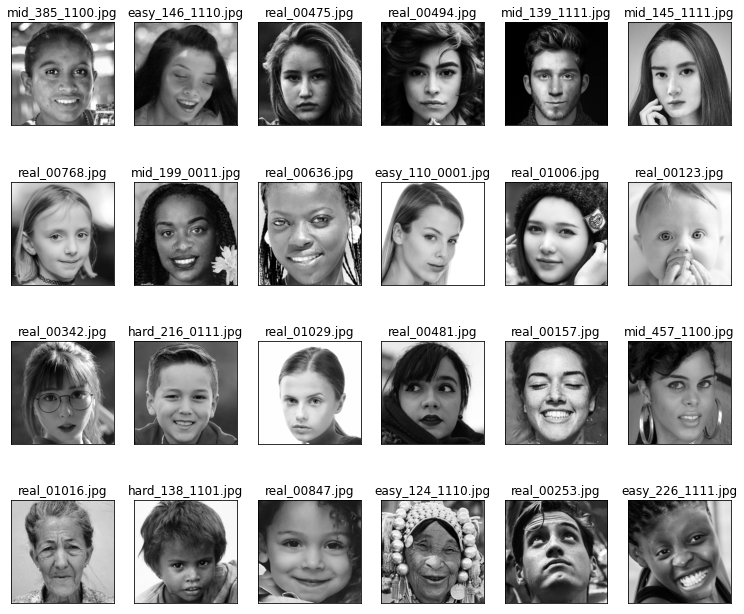

In [22]:
#Helper function taken from your "04. Dimension Reduction and Images" notebook
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(data, names, h, w, n_row=4)

This output gives us a good idea of what our data set looks like. We have an assortment of real and fake images, including at least one of each fake category.

Because we can easily tell the fake images are edited by only looking at them in grayscale, we decided to keep them as such, as it saves memory and RGB images would only complicate PCA and feature extraction later on in our report. 

## 3. Data Reduction

### 3.1 Linear Dimensionality Reduction Using Principal Components Analysis

In [23]:
#Helper function taken from your "04. Dimension Reduction and Images" notebook
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

In [37]:
from sklearn.decomposition import PCA

components = 400
print(f'Extracting the top {components} eigenfaces from {data.shape[0]} faces')

pca = PCA(n_components=components)
%time pca.fit(data.copy())
eigenfaces_pca = pca.components_.reshape((components, h, w))

Extracting the top 400 eigenfaces from 2041 faces
CPU times: user 2min 21s, sys: 8.81 s, total: 2min 30s
Wall time: 43.5 s


In [38]:
plot_explained_variance(pca)

From this explained variance graph, we can see that 400 principal components explains roughly 95% of our data. We settled on 400 components because we wanted enough components to explain at least 95% of the data and the graph is beginning to plataeu.

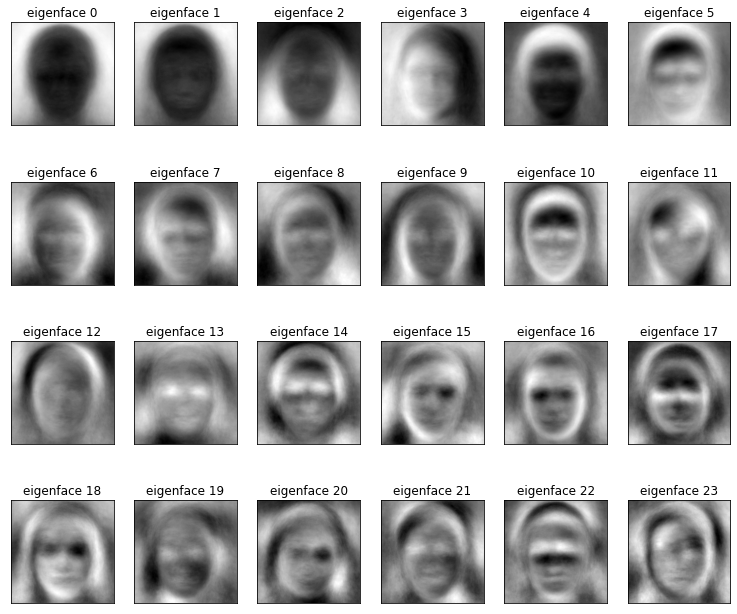

In [39]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_pca.shape[0])]
plot_gallery(eigenfaces_pca, eigenface_titles, h, w, n_row=4)

As we can see from the displayed eigenfaces, the higher numbered eigenface is a much more defined representation of a face compared to lower numbered eigenfaces. Looking at eigenface 0, there are no defined facial features, but as the number increases, eyes, noses, and mouths become generally more distinguished. 

We noticed a large portion of the displayed eigenfaces seem to be representations of women. We assume this could be the case due to a greater number of women in the image dataset or due to personal bias from us percieving the pixel value differences around the head as long-flowing hair. 

### 3.2 Linear Dimensionality Reduction Using Randomized Principal Components Analysis

In [40]:
print(f'Extracting the top {components} eigenfaces from {data.shape[0]} faces')

rpca = PCA(n_components=components, svd_solver='randomized')
%time rpca.fit(data.copy())
eigenfaces_rpca = rpca.components_.reshape((components, h, w))

Extracting the top 400 eigenfaces from 2041 faces
CPU times: user 2min 5s, sys: 8.62 s, total: 2min 13s
Wall time: 39.4 s


In [41]:
plot_explained_variance(rpca)

From this graph we can tell that 400 components for randomized PCA explains around 95% of the data, which is the same for 400 components with full PCA. 

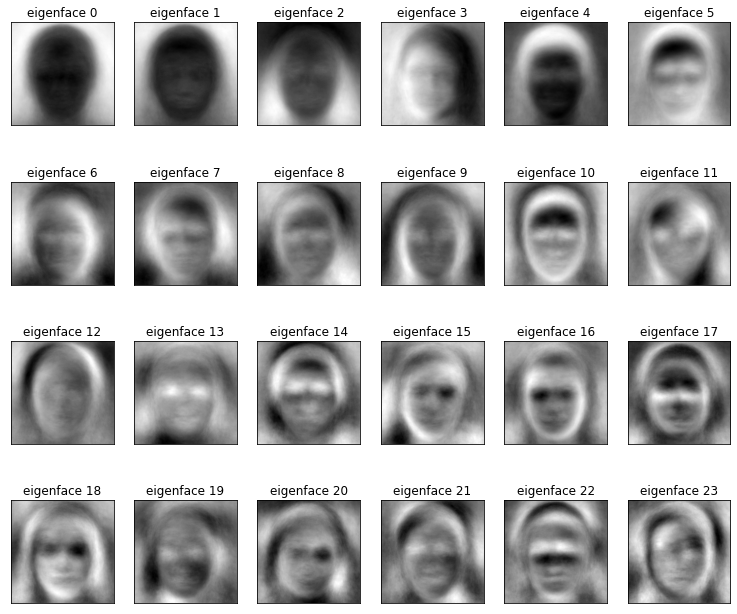

In [42]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_rpca.shape[0])]
plot_gallery(eigenfaces_rpca, eigenface_titles, h, w, n_row=4)

Looking at these eigenfaces for randomized PCA, we could not identify any noticeable differences between randomized PCA and full PCA. That being said, there could be very minute differences unable to be seen with the naked eye at this small of a scale. To compare and contrast the differences between full PCA and randomized PCA, we will need to look at statistical differences rather than visual differences. 

### 3.3 Comparing PCA and Randomized PCA

In [49]:
def reconstruct_img(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

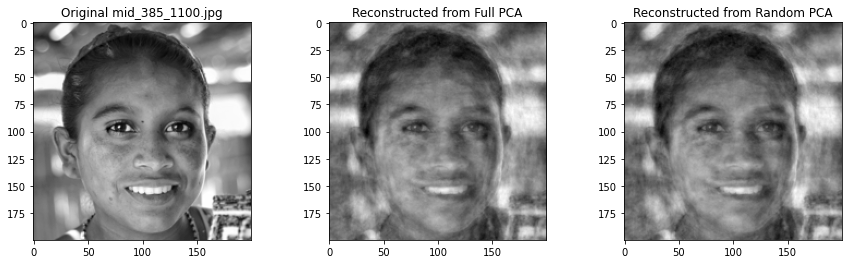

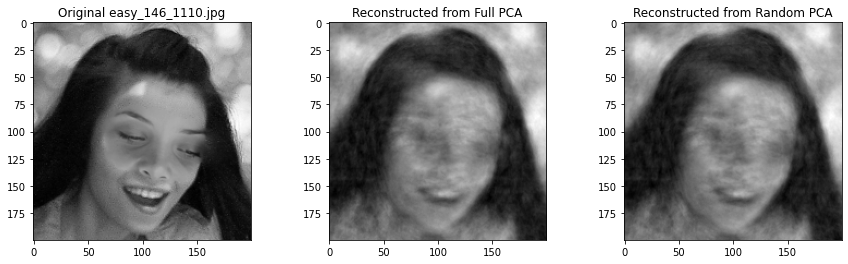

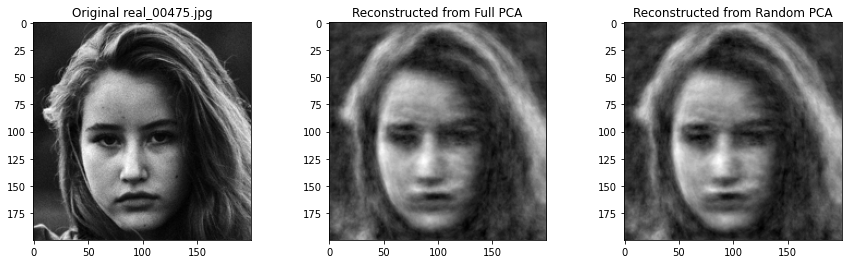

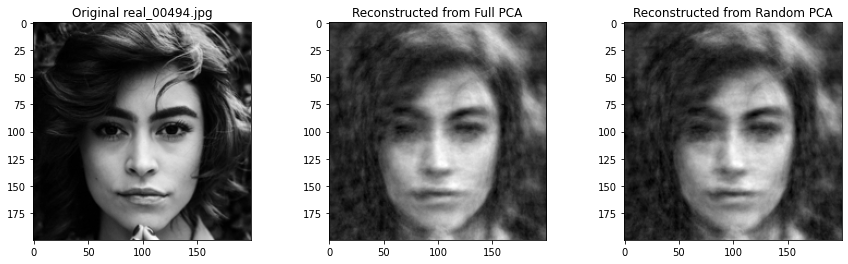

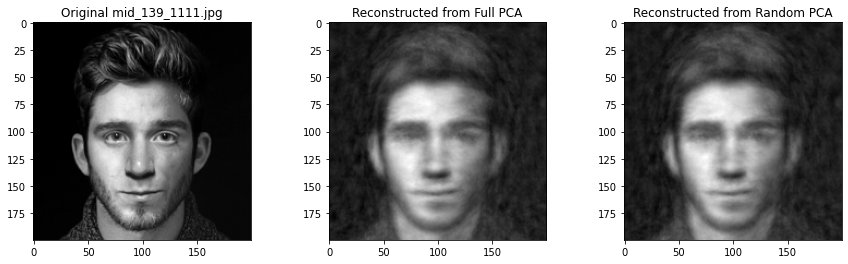

In [53]:
for idx_to_reconstruct in range(0, 5):
    data_idx = data[idx_to_reconstruct]
    low_dim_represent, reconstruct_img_pca = reconstruct_img(pca,data_idx.reshape(1, -1))
    low_dim_represent, reconstruct_img_rpca = reconstruct_img(rpca,data_idx.reshape(1,-1))
    
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.imshow(data_idx.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original ' + names[idx_to_reconstruct])
    plt.grid(False)
    plt.subplot(1,3,2)
    plt.imshow(reconstruct_img_pca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Reconstructed from Full PCA')
    plt.grid(False)
    plt.subplot(1,3,3)
    plt.imshow(reconstruct_img_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Reconstructed from Random PCA')
    plt.grid(False)

From this small sample size of reconstructed images of our dataset, we cannot visually discern any glaring difference between full and randomized PCA. 

One thing we would like to note is the reconstruction of the "easy_146_1110" image. This image seems to be an outlier of our small sample size in that it's reconstruction is substantially worse compared to the others. We speculate this is due to the image being heavily edited and very easily identified as fake. However, this phenomena could also be due to the way the person is looking down at the ground rather than at the camera.

In [71]:
from sklearn.metrics import mean_squared_error

avg_mse_pca = 0
avg_mse_rpca = 0
num_images = 200
#only run through small sample size images b\c computationally intensive
for idx_to_reconstruct in range(num_images):
    data_idx = data[idx_to_reconstruct]
    #reconstruct image using full PCA and randomized PCA
    low_dim_represent, reconstruct_img_pca = reconstruct_img(pca,data_idx.reshape(1, -1))
    low_dim_represent, reconstruct_img_rpca = reconstruct_img(rpca,data_idx.reshape(1,-1))
    #flatten images to shape of (40000,) arrays
    reconstruct_img_pca = reconstruct_img_pca.flatten()
    reconstruct_img_rpca = reconstruct_img_rpca.flatten()
    #find MSE and add to average MSE for respective reduction method
    avg_mse_pca += mean_squared_error(data_idx, reconstruct_img_pca)
    avg_mse_rpca += mean_squared_error(data_idx, reconstruct_img_rpca)
    print(idx_to_reconstruct, end='\r')

#print average MSE (divide by num_images to get average) 
print('Average MSE for PCA:', avg_mse_pca / num_images)
print('Average MSE for randomized PCA:', avg_mse_rpca / num_images)

Average MSE for PCA: 199.11051588856853
Average MSE for randomized PCA: 199.53094667770702


We decided to take the average mean squared error of both full PCA and randomized PCA for the first 200 images (we only did the first 200 as reconstructing the images was quite computationally intensive and we assumed we would get a solid understanding of the MSE with this sample size). As we can see from the average MSE for both full and randomized PCA, there is very little difference between the two dimensionality reduction methods, with PCA having a very slight advantage. Additionally, looking back at the explained variance ratio graphs, we can see that the number of components that explain the data is roughly, if not exactly, the same for both randomized and full PCA. For these reasons, we believe that either dimensionality reduction method is acceptable to use for this dataset.

If we had to nit-pick, randomized PCA was a few seconds faster to fit compared to full PCA, however this could easily change due to hardware capabilities because the margin is so small.

### 3.4 Feature Extraction

In [ ]:
from skimage.io import imshow
from skimage.feature import daisy

idx_to_reconstruct = int(np.random.rand(1)*len(data))

#plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
img = data[idx_to_reconstruct].reshape((h, w))
imshow(img)

plt.subplot(1,2,2)
feats, img_desc = daisy(img, step=40, radius=30, rings=2, histograms=8,
                       orientations=4, visualize=True)
imshow(img_desc)
plt.grid(False)

print(feats.shape)
print(feats.shape[0]*feats.shape[1]*feats.shape[2])

Performing DAISY over our entire dataset took just about 3 minutes. We consider this a reasonable time for feature extraction on a dataset of over 2000 images with each being 200x200 pixels.

### 3.5 Analysis of Feature Extraction for Prediction Task

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

for _ in range(0,5):
    # find closest image to current image
    idx1 = int(np.random.rand(1)*len(data))
    distances = copy.deepcopy(dist_matrix[idx1,:])
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)

    plt.figure(figsize=(7,10))
    plt.subplot(1,2,1)
    imshow(data[idx1].reshape((h,w)))
    plt.title("Original Image " + str(idx1))
    plt.grid()

    plt.subplot(1,2,2)
    imshow(data[idx2].reshape((h,w)))
    plt.title("Closest Image" + str(idx2))
    plt.grid()

After running the above code block a few times, we realized that there are edited and unedited images of the same person in our dataset. Our feature extraction model was able to identify these images as being related using the pairwise distance, however for the most part, the two images found to be related were not in fact related. This is a consequence of our dataset as a majority of the images included to not have edited and non-edited versions of the same picture. Therefore this method of analysis is suited for our dataset. Because of this, we decided to try a K-nearest-neighbor classifier with our extracted features to see if it produced better results.

In [ ]:
knn_dsy = KNeighborsClassifier(n_neighbors=3)

dsy_train, dsy_test, y_train, y_test = train_test_split(daisy_features,
                                                        classification,
                                                        test_size=0.2,
                                                        train_size=0.8)

knn_dsy.fit(dsy_train,y_train)
acc_dsy = accuracy_score(knn_dsy.predict(dsy_test),y_test)

print(f"Daisy Accuracy:{100*acc_dsy:.2f}%".format())

As we can see, the accuracy of our nearest-neighbor classifier using the extracted DAISY features is only slightly better than a coin flip. Because we stated that a successful prediction algorithm would need to be in the 95% to 98% accuracy range, DAISY feature extraction falls extremely short of what we need for a edited or non-edited image prediction task.

## 4. Exceptional Work: Logistic Regression

For our exceptional work, we decided to try using logistic regression on our dataset to predict whether a given image is fake or real.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import copy

#normalize the data
datacopy = copy.deepcopy(data)
scaler = StandardScaler().fit_transform(datacopy)

data_train, data_test, y_train, y_test = train_test_split(scaler,
                                                          classification,
                                                          test_size=0.2,
                                                          train_size=0.8)

regression = LogisticRegression(max_iter=1500)
%time regression.fit(data_train, y_train)

print('model coefficients are:', regression.coef_)
print('model intercept is', regression.intercept_)
print('model classes are', regression.classes_)

n the above block, we started off by normalizing our dataset as the regression would not converge if we gave it the raw data. After normalizing we split the processed data into training and testing sets. We then fit the logistic regression model to our training data and output the coefficients, intercept and different classification classes.

Looking at the time taken to fit the logistic regression model, we can see that it was significantly faster to train compared to DAISY feature extraction. Depending on the accuracy, this could be a better alternative for classification.

In [ ]:
y_hat = regression.predict(data_test)
acc = accuracy_score(y_hat,y_test)

print(f"Regression Accuracy: {100*acc:.2f}%".format())

Unfortunately, once again the accuracy is far below our desired percentage needed for a successful prediction algorithm. The accuracy of logistic regression is slightly worse than the DAISY and K-nearest-neighbor combination but the time taken to fit the model is quite less. Since the accuracies are comparable, if you are willing to sacrifice some accuracy for time, logistic regression would be a good model to use.

After analyzing these various prediction algorithms and getting poor accuracies, it is clear that this dataset is not suited for these types of prediction algorithms. We believe we will have more success utilizing neural networks to classify this dataset into fake or not fake images.

## References

1. Real and Fake Face Dataset. https://www.kaggle.com/ciplab/real-and-fake-face-detection